# Explanation
Samples are generated as a "poisson random walk" where the CN in first state is random poisson, and then the following CN=CN+jump where jump is a poisson random variable. Two clusters were simulated using different jump, initialization parameters and then they were clustered.

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


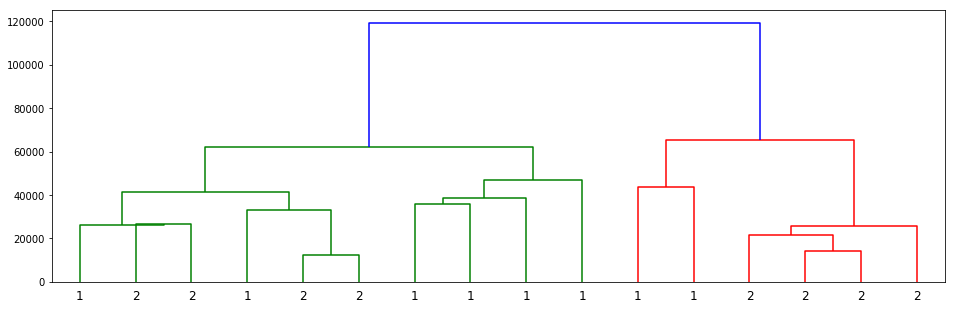

In [4]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 8
NUM_BIN = 500
CHR_NAMES = ["1","2"]
max_cn=7

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
plinkage["dist"] = -1 * plinkage["r_merge"]
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")

cl_cell_ids = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 5))
dend = dendrogram(plot_data, labels=cl_cell_ids)

# Analysis
Doesn't work too well. The y-axis is `-marginal_log_likelihood` and the values are quite high so I question it. Should be getting good clustering

In [2]:
clustering = pd.DataFrame()
clustering["sample_inds"] = list(range(cn_mat.shape[0]))
clustering["cell_id"] = cell_ids
clustering["exp_cl"] = clustering["cell_id"].str[2]

left_samples = [x.sample_inds[0] for x in root.left_child.get_leaves()]
right_samples = [x.sample_inds[0] for x in root.right_child.get_leaves()]


def fn(ind):
    if ind in left_samples:
        return "1"
    elif ind in right_samples:
        return "2"
clustering["obs_cl"] = clustering["sample_inds"].apply(fn)

def get_prop_correct(clustering):
    return max((clustering["exp_cl"] == clustering["obs_cl"]).value_counts() / clustering.shape[0])

print(f"proportion clustering: {get_prop_correct(clustering)}")

proportion clustering: 0.625


# Repeating over many trials

In [7]:
NUM_TRIALS = 10
NUM_SAMPLE = 8
NUM_BIN = 500
CHR_NAMES = ["1","2"]
MAX_CN=7

def simulate_bayes_cluster(df, num_sample=NUM_SAMPLE, num_bin=NUM_BIN, chr_names=CHR_NAMES, max_cn=MAX_CN):
    cluster1 = sim.cn_mat_poisson(num_sample, num_bin, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
    cluster2 = sim.cn_mat_poisson(num_sample, num_bin, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

    clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
    clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

    cn_mat = np.concatenate([cluster1, cluster2])
    df["cn_mat"] = cn_mat
    cell_ids = clst1_cell_ids + clst2_cell_ids

    df_cn_mat = cn_mat_as_df(cn_mat, chr_names)
    cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
    cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
    cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
    cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

    tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

    plinkage = tlinkage[["i","j","r_merge","merge_count"]]
    plinkage["r_merge"] = plinkage["r_merge"].astype("float")
    plinkage["dist"] = -1 * plinkage["r_merge"]
    plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")
    df["plot_data"] = plot_data
   
    clustering = pd.DataFrame()
    clustering["sample_inds"] = list(range(cn_mat.shape[0]))
    clustering["cell_id"] = cell_ids
    clustering["exp_cl"] = clustering["cell_id"].str[2]
    df["clustering"] = clustering

    left_samples = [x.sample_inds[0] for x in root.left_child.get_leaves()]
    right_samples = [x.sample_inds[0] for x in root.right_child.get_leaves()]

    def fn(ind):
        if ind in left_samples:
            return "1"
        elif ind in right_samples:
            return "2"
    clustering["obs_cl"] = clustering["sample_inds"].apply(fn)

    prop_correct = get_prop_correct(clustering)
    
    df["prop_correct"] = prop_correct    
    return df

sims = pd.DataFrame(list(range(NUM_TRIALS)), columns=["id"])
sims = sims.apply(simulate_bayes_cluster, axis=1)

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


id                                             cn_mat  \
0   0  [[1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 6, 7, 5, 7,...   
1   1  [[1, 0, 0, 0, 2, 2, 2, 4, 4, 2, 1, 0, 0, 0, 0,...   
2   2  [[0, 1, 4, 4, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7,...   
3   3  [[2, 1, 3, 3, 2, 1, 0, 2, 1, 0, 0, 1, 3, 3, 4,...   
4   4  [[0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0,...   

                                           plot_data  \
0  [[9.0, 15.0, 13081.071705814178, 2.0], [8.0, 1...   
1  [[11.0, 15.0, 12561.464239198434, 2.0], [8.0, ...   
2  [[11.0, 14.0, 19178.746871580268, 2.0], [16.0,...   
3  [[8.0, 13.0, 13415.902304800806, 2.0], [9.0, 1...   
4  [[8.0, 11.0, 18754.41220305837, 2.0], [10.0, 1...   

                                          clustering  prop_correct  
0      sample_inds    cell_id exp_cl obs_cl
0    ...        0.8125  
1      sample_inds    cell_id exp_cl obs_cl
0    ...        0.7500  
2      sample_inds    cell_id exp_cl obs_cl
0    ...        0.7500  
3      sample_inds    cell_id exp_cl obs_cl
0    ...        0.7500  
4      sample_inds    cell_id exp_cl obs_cl
0    ...        0.6250

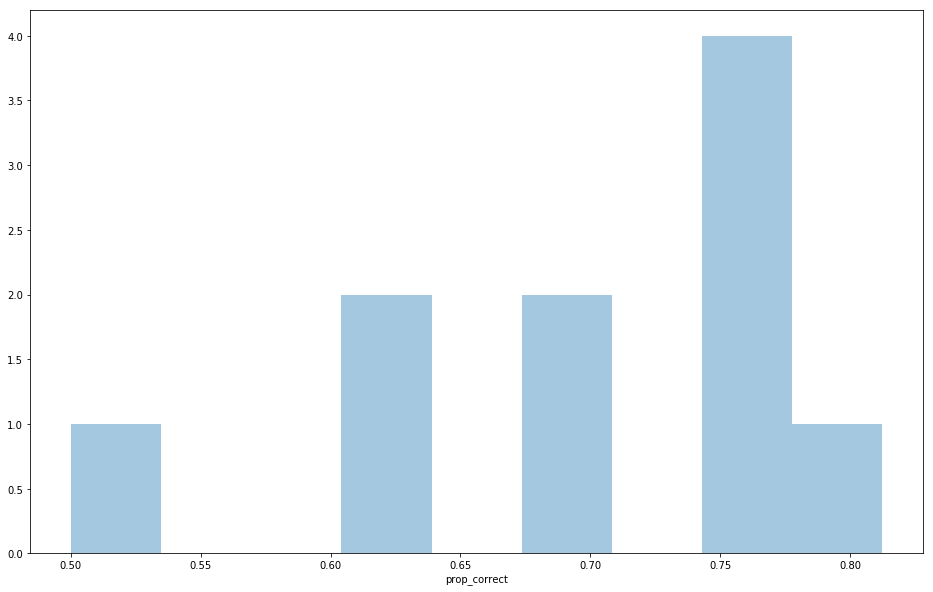

In [8]:
import seaborn as sns
display(sims.head())
fig = plt.figure(figsize=(16, 10))
sns.distplot(sims["prop_correct"], kde=False, bins=9)

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



i   j        r_merge           dist merge_count
0   13  15   -2326.720237    2326.720237           2
1    9  11   -4630.805200    4630.805200           2
2   17  10   -6093.020118    6093.020118           3
3   12  16   -7740.667277    7740.667277           3
4    4  14  -11851.481245   11851.481245           2
5    2  20  -12693.526106   12693.526106           3
6   18  19  -17063.230242   17063.230242           6
7    0  21  -18880.934866   18880.934866           4
8    5   7  -19755.869528   19755.869528           2
9    1  24  -24768.890709   24768.890709           3
10  23   8  -25441.623717   25441.623717           5
11  25   3  -27707.645211   27707.645211           4
12  26   6  -34251.596142   34251.596142           6
13  28  27  -49889.615790   49889.615790          10
14  29  22 -153665.279355  153665.279355          16

chr  bin    cell_id  state  start  end cluster_id      copy
0   1    0  cl1_cell0      1      0    9        cl1  1.125027
1   1    1  cl1_cell0      0     10   19        cl1  0.016880
2   1    2  cl1_cell0      0     20   29        cl1  0.640859
3   1    3  cl1_cell0      0     30   39        cl1  0.492081
4   1    4  cl1_cell0      0     40   49        cl1  0.538031

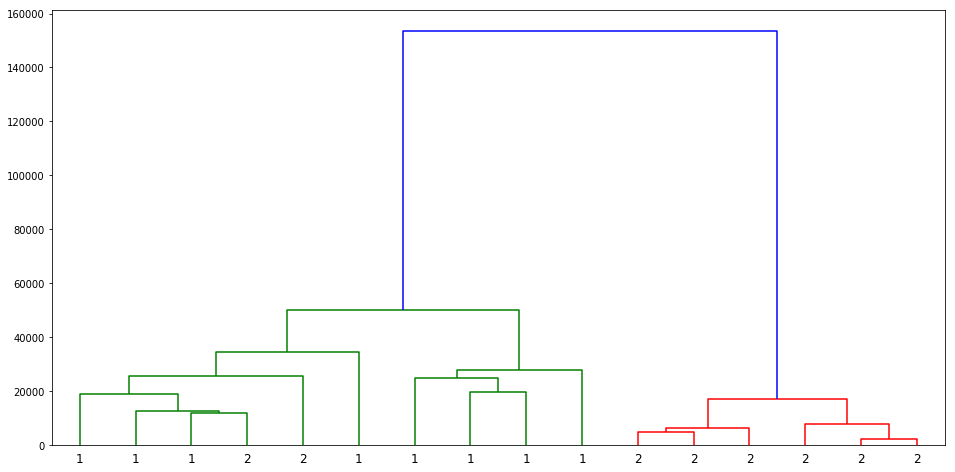

In [4]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 8
NUM_BIN = 300
CHR_NAMES = ["1","2"]
ALPHA=0.05
MAX_CN=7
NOISE_SEED=2

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1, seed=1, max_cn=MAX_CN)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=3, max_cn=MAX_CN)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
if NOISE_SEED is not None:
    np.random.seed(NOISE_SEED)
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=MAX_CN, value_ids=["copy"], alpha=ALPHA)

from scipy.stats import rankdata

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
if(plinkage["r_merge"].min() < 0):
    plinkage["dist"] = rankdata(-1*plinkage["r_merge"])
    #plinkage["dist"] = plinkage["r_merge"] +  -1 * plinkage["r_merge"].min() + 1
    #plinkage["dist1"] = plinkage["dist"].min() / plinkage["dist"] 
else:
    pass
#####
#plinkage.loc[0,"r_merge"] = 1
#plinkage["dist"] = np.exp((1/plinkage["r_merge"]))
#plinkage["dist"] = plinkage["r_merge"].min() / plinkage["r_merge"]
plinkage["dist"] = -1 * plinkage["r_merge"]
#####
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")
display(plinkage[["i","j","r_merge","dist","merge_count"]])
display(cn_data.head())


cell_id_labels = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 8))
dend = dendrogram(plot_data, labels=cell_id_labels)

/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["r_merge"] = plinkage["r_merge"].astype("float")
/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["dist"] = -1 * plinkage["r_merge"]


i   j        r_merge           dist merge_count
0   13  15   -2326.720237    2326.720237           2
1    9  11   -4630.805200    4630.805200           2
2   17  10   -6093.020118    6093.020118           3
3   12  16   -7740.667277    7740.667277           3
4    4  14  -11851.481245   11851.481245           2
5    2  20  -12693.526106   12693.526106           3
6   18  19  -17063.230242   17063.230242           6
7    0  21  -18880.934866   18880.934866           4
8    5   7  -19755.869528   19755.869528           2
9    1  24  -24768.890709   24768.890709           3
10  23   8  -25441.623717   25441.623717           5
11  25   3  -27707.645211   27707.645211           4
12  26   6  -34251.596142   34251.596142           6
13  28  27  -49889.615790   49889.615790          10
14  29  22 -153665.279355  153665.279355          16

chr  bin    cell_id  state  start  end cluster_id      copy
0   1    0  cl1_cell0      1      0    9        cl1  1.125027
1   1    1  cl1_cell0      0     10   19        cl1  0.016880
2   1    2  cl1_cell0      0     20   29        cl1  0.640859
3   1    3  cl1_cell0      0     30   39        cl1  0.492081
4   1    4  cl1_cell0      0     40   49        cl1  0.538031

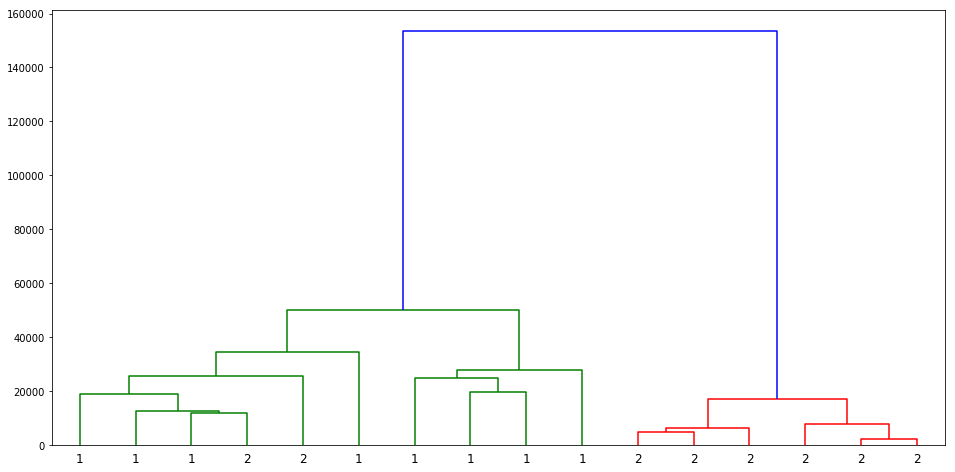

In [5]:
from scgenome import simulation
cn_data, plinkage, plot_data, clustering, prop_correct = (
    simulation.poisson_bicluster(NUM_SAMPLE, NUM_BIN, MAX_CN, ALPHA, init_lambdas=(1, 3), jump_lambdas=(1, 0.1), seeds=(1, 3), noise_seed=2))

display(plinkage[["i","j","r_merge","dist","merge_count"]])
display(cn_data.head())


cell_id_labels = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 8))
dend = dendrogram(plot_data, labels=cell_id_labels)

In [6]:
from scgenome.simulation import many_poisson_bicluster
foo = many_poisson_bicluster(3, [4], [50,100], [7], [0.1,0.3], [(3,1)], [(1, 0.1)])

/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["r_merge"] = plinkage["r_merge"].astype("float")
/Users/massoudmaher/Documents/Code/scgenome/scgenome/simulation.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plinkage["dist"] = -1 * plinkage["r_merge"]


In [17]:
foo["cn_data"].iloc[0]

chr  bin    cell_id  state  start  end cluster_id      copy
0     1    0  cl1_cell0      0      0    9        cl1  0.500966
1     1    1  cl1_cell0      1     10   19        cl1  1.210574
2     1    2  cl1_cell0      2     20   29        cl1  2.535331
3     1    3  cl1_cell0      0     30   39        cl1  0.019376
4     1    4  cl1_cell0      0     40   49        cl1  0.303713
5     1    5  cl1_cell0      1     50   59        cl1  1.308184
6     1    6  cl1_cell0      1     60   69        cl1  1.526941
7     1    7  cl1_cell0      1     70   79        cl1  1.332099
8     1    8  cl1_cell0      0     80   89        cl1  0.121646
9     1    9  cl1_cell0      1     90   99        cl1  1.172281
10    1   10  cl1_cell0      3    100  109        cl1  3.263923
11    1   11  cl1_cell0      3    110  119        cl1  3.038620
12    1   12  cl1_cell0      2    120  129        cl1  2.249086
13    1   13  cl1_cell0      4    130  139        cl1  4.050862
14    1   14  cl1_cell0      5    140  149        cl1  5.074456
15    1   15  cl1_cell0      6    150  159        cl1  6.274926
16    1   16  cl1_cell0      5    160  169        cl1  5.539250
17    1   17  cl1_cell0      4    170  179        cl1  4.293320
18    1   18  cl1_cell0      5    180  189        cl1  5.247241
19    1   19  cl1_cell0      5    190  199        cl1  5.452470
20    1   20  cl1_cell0      6    200  209        cl1  6.310716
21    1   21  cl1_cell0      6    210  219        cl1  6.016653
22    1   22  cl1_cell0      5    220  229        cl1  5.057158
23    1   23  cl1_cell0      4    230  239        cl1  4.327861
24    1   24  cl1_cell0      4    240  249        cl1  4.125805
25    2   25  cl1_cell0      4    250  259        cl1  4.203150
26    2   26  cl1_cell0      5    260  269        cl1  5.260426
27    2   27  cl1_cell0      4    270  279        cl1  4.592828
28    2   28  cl1_cell0      4    280  289        cl1  4.006610
29    2   29  cl1_cell0      3    290  299        cl1  3.267993
..   ..  ...        ...    ...    ...  ...        ...       ...
370   1   20  cl2_cell3      1    200  209        cl2  1.144089
371   1   21  cl2_cell3      1    210  219        cl2  1.082336
372   1   22  cl2_cell3      1    220  229        cl2  1.094539
373   1   23  cl2_cell3      0    230  239        cl2  0.251449
374   1   24  cl2_cell3      0    240  249        cl2  0.009867
375   2   25  cl2_cell3      1    250  259        cl2  1.130073
376   2   26  cl2_cell3      1    260  269        cl2  1.246065
377   2   27  cl2_cell3      1    270  279        cl2  1.187434
378   2   28  cl2_cell3      1    280  289        cl2  1.064262
379   2   29  cl2_cell3      2    290  299        cl2  2.040870
380   2   30  cl2_cell3      2    300  309        cl2  2.042280
381   2   31  cl2_cell3      2    310  319        cl2  2.086950
382   2   32  cl2_cell3      2    320  329        cl2  2.124814
383   2   33  cl2_cell3      0    330  339        cl2  0.175415
384   2   34  cl2_cell3      0    340  349        cl2  0.191541
385   2   35  cl2_cell3      0    350  359        cl2  0.622327
386   2   36  cl2_cell3      0    360  369        cl2  0.111362
387   2   37  cl2_cell3      0    370  379        cl2  0.441382
388   2   38  cl2_cell3      0    380  389        cl2  0.113079
389   2   39  cl2_cell3      0    390  399        cl2  0.232365
390   2   40  cl2_cell3      0    400  409        cl2  0.063460
391   2   41  cl2_cell3      0    410  419        cl2  0.128539
392   2   42  cl2_cell3      0    420  429        cl2  0.117262
393   2   43  cl2_cell3      0    430  439        cl2  0.206795
394   2   44  cl2_cell3      0    440  449        cl2  0.244196
395   2   45  cl2_cell3      0    450  459        cl2  0.392477
396   2   46  cl2_cell3      0    460  469        cl2  0.138247
397   2   47  cl2_cell3      0    470  479        cl2  0.193077
398   2   48  cl2_cell3      0    480  489        cl2  0.047954
399   2   49  cl2_cell3      0    490  499        cl2  0.269429

[400 rows x 8 columns]

In [12]:
foo

samples_per_cluster  num_bin  max_cn  alpha init_lambdas jump_lambdas  \
0                    4       50       7    0.1       (3, 1)     (1, 0.1)   
1                    4       50       7    0.3       (3, 1)     (1, 0.1)   
2                    4      100       7    0.1       (3, 1)     (1, 0.1)   
3                    4      100       7    0.3       (3, 1)     (1, 0.1)   
0                    4       50       7    0.1       (3, 1)     (1, 0.1)   
1                    4       50       7    0.3       (3, 1)     (1, 0.1)   
2                    4      100       7    0.1       (3, 1)     (1, 0.1)   
3                    4      100       7    0.3       (3, 1)     (1, 0.1)   
0                    4       50       7    0.1       (3, 1)     (1, 0.1)   
1                    4       50       7    0.3       (3, 1)     (1, 0.1)   
2                    4      100       7    0.1       (3, 1)     (1, 0.1)   
3                    4      100       7    0.3       (3, 1)     (1, 0.1)   

                                             cn_data  \
0      chr  bin    cell_id  state  start  end clu...   
1      chr  bin    cell_id  state  start  end clu...   
2      chr  bin    cell_id  state  start  end clu...   
3      chr  bin    cell_id  state  start  end clu...   
0      chr  bin    cell_id  state  start  end clu...   
1      chr  bin    cell_id  state  start  end clu...   
2      chr  bin    cell_id  state  start  end clu...   
3      chr  bin    cell_id  state  start  end clu...   
0      chr  bin    cell_id  state  start  end clu...   
1      chr  bin    cell_id  state  start  end clu...   
2      chr  bin    cell_id  state  start  end clu...   
3      chr  bin    cell_id  state  start  end clu...   

                                            plinkage  \
0      i   j      r_merge merge_count         dis...   
1      i   j       r_merge merge_count          d...   
2      i   j       r_merge merge_count          d...   
3      i  j       r_merge merge_count          di...   
0      i   j       r_merge merge_count          d...   
1      i   j      r_merge merge_count         dis...   
2      i   j       r_merge merge_count          d...   
3      i   j       r_merge merge_count          d...   
0      i   j       r_merge merge_count          d...   
1      i   j       r_merge merge_count          d...   
2      i   j       r_merge merge_count          d...   
3      i   j       r_merge merge_count          d...   

                                           plot_data  \
0  [[4.0, 5.0, 90.53023970349193, 2.0], [8.0, 7.0...   
1  [[4.0, 7.0, 238.15062342328736, 2.0], [8.0, 6....   
2  [[4.0, 7.0, 1609.7664274317565, 2.0], [0.0, 5....   
3  [[4.0, 6.0, 2082.081377884146, 2.0], [8.0, 7.0...   
0  [[4.0, 5.0, 376.3332243407757, 2.0], [8.0, 7.0...   
1  [[4.0, 5.0, 814.5994033028761, 2.0], [0.0, 6.0...   
2  [[5.0, 6.0, 1252.2214157595167, 2.0], [4.0, 8....   
3  [[5.0, 7.0, 2805.1053396344014, 2.0], [0.0, 8....   
0  [[4.0, 6.0, 300.45277097863607, 2.0], [8.0, 5....   
1  [[4.0, 6.0, 261.79066774989576, 2.0], [5.0, 7....   
2  [[4.0, 5.0, 481.72173746835574, 2.0], [8.0, 6....   
3  [[4.0, 6.0, 443.81585220828157, 2.0], [5.0, 7....   

                                          clustering  prop_correct  
0     sample_inds    cell_id exp_cl obs_cl
0     ...         0.750  
1     sample_inds    cell_id exp_cl obs_cl
0     ...         0.750  
2     sample_inds    cell_id exp_cl obs_cl
0     ...         0.625  
3     sample_inds    cell_id exp_cl obs_cl
0     ...         0.875  
0     sample_inds    cell_id exp_cl obs_cl
0     ...         0.750  
1     sample_inds    cell_id exp_cl obs_cl
0     ...         0.625  
2     sample_inds    cell_id exp_cl obs_cl
0     ...         0.625  
3     sample_inds    cell_id exp_cl obs_cl
0     ...         0.625  
0     sample_inds    cell_id exp_cl obs_cl
0     ...         0.875  
1     sample_inds    cell_id exp_cl obs_cl
0     ...         1.000  
2     sample_inds    cell_id exp_cl obs_cl
0     ...         0.750  